In [1]:
import os
from omegaconf import OmegaConf
from hovsg.graph.graph import Graph
from hydra import initialize, compose
import open3d as o3d
import torch
import networkx as nx
import numpy as np
from scipy.spatial import cKDTree
from tqdm import tqdm

import open_clip
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from hovsg.utils.constants import MATTERPORT_GT_LABELS, CLIP_DIM

from hovsg.dataloader.hm3dsem import HM3DSemDataset
from hovsg.dataloader.scannet import ScannetDataset
from hovsg.dataloader.replica import ReplicaDataset
from hovsg.dataloader.truckscenes import TruckScenesDataset
import matplotlib.pyplot as plt
from hovsg.models.sam_clip_feats_extractor import extract_feats_per_pixel

from hovsg.utils.graph_utils import (
    seq_merge,
    pcd_denoise_dbscan,
    feats_denoise_dbscan,
    distance_transform,
    map_grid_to_point_cloud,
    compute_room_embeddings,
    find_intersection_share,
    hierarchical_merge,
)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # or "1", "0,1", etc.

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:

# Manually initialize Hydra and load the config
config_path = "../config"
config_name = "semantic_segmentation"

# Hydra context for manual loading
with initialize(version_base=None, config_path=config_path):
    params = compose(config_name=config_name)

# Create save directory
save_dir = os.path.join(params.main.save_path, params.main.dataset)
os.makedirs(save_dir, exist_ok=True)

In [3]:
cfg = params
full_pcd = o3d.geometry.PointCloud()
mask_feats = []
mask_feats_d = []
mask_pcds = []
mask_weights = []
objects = []
rooms = []
floors = []
full_feats_array = []
graph = nx.Graph()
graph.add_node(0, name="building", type="building")
room_masks = {}
device = "cuda" if torch.cuda.is_available() else "cpu"

# load CLIP model
if cfg.models.clip.type == "ViT-L/14@336px":
    clip_model, _, preprocess = open_clip.create_model_and_transforms(
        "ViT-L-14",
        pretrained=str(cfg.models.clip.checkpoint),
        device=device,
    )
    clip_feat_dim = CLIP_DIM["ViT-L-14"]
    # clip_feat_dim = constants.clip_feat_dim[cfg.models.clip.type]
elif cfg.models.clip.type == "ViT-H-14":
    clip_model, _, preprocess = open_clip.create_model_and_transforms(
        "ViT-H-14",
        pretrained=str(cfg.models.clip.checkpoint),
        device=device,
    )
    clip_feat_dim = CLIP_DIM["ViT-H-14"]
clip_model.eval()
if not hasattr(cfg, "pipeline"):
    print("-- entering querying and evaluation mode")
    # return

graph_tmp_folder = os.path.join(cfg.main.save_path, "tmp")
if not os.path.exists(graph_tmp_folder):
    os.makedirs(graph_tmp_folder)

# load the SAM model
model_type = cfg.models.sam.type
sam = sam_model_registry[model_type](
    checkpoint=str(cfg.models.sam.checkpoint)
)
sam.to(device=device)
# load the dataset
dataset_cfg = {"root_dir": cfg.main.dataset_path, "transforms": None}
if cfg.main.dataset == "hm3dsem":
    dataset = HM3DSemDataset(dataset_cfg)
elif cfg.main.dataset == "scannet":
    dataset = ScannetDataset(dataset_cfg)
elif cfg.main.dataset == "replica":
    dataset = ReplicaDataset(dataset_cfg)
elif cfg.main.dataset == "truckscenes":
    dataset = TruckScenesDataset(dataset_cfg, scene="scene-0c2e941c5ba2476b9e20b29ce4c678b9-3")
else:
    print("Dataset not supported")

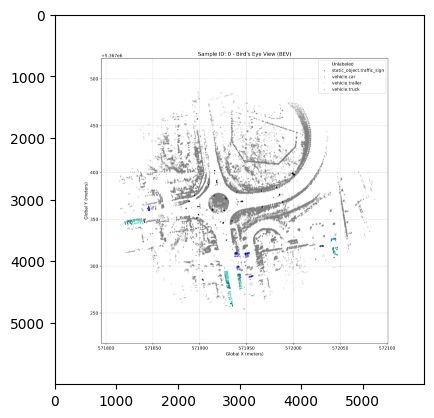

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

# scine = "scene-0044384af3d8494e913fb8b14915239e-8"
scine = "scene-0c2e941c5ba2476b9e20b29ce4c678b9-3"
impath = f"/shared/data/truckScenes/truckscenes_converted/trainval/{scine}/labelled_map_plot.png"
image = Image.open(impath)

plt.imshow(image)

In [5]:

if dataset is None:
    print("No dataset loaded")

# create the RGB-D point cloud
for i in tqdm(range(0, len(dataset), cfg.pipeline.skip_frames), desc="Creating RGB-D point cloud"):
    rgb_image, depth_image, pose, _, depth_intrinsics = dataset[i]
    new_pcd = dataset.create_pcd(rgb_image, depth_image, pose)
    full_pcd += new_pcd

# filter point cloud
print("Size before filtering:", len(full_pcd.points))
full_pcd = full_pcd.voxel_down_sample(
    voxel_size=cfg.pipeline.voxel_size
)
# full_pcd = pcd_denoise_dbscan(full_pcd, eps=0.01, min_points=100)
print("Size after filtering:", len(full_pcd.points))
# create tree from full point cloud
locs_in = np.array(full_pcd.points)
tree_pcd = cKDTree(locs_in)
n_points = locs_in.shape[0]
counter = torch.zeros((n_points, 1), device="cpu")
sum_features = torch.zeros((n_points, clip_feat_dim), device="cpu")


Creating RGB-D point cloud: 100%|██████████| 160/160 [00:04<00:00, 36.10it/s]


Size before filtering: 396085
Size after filtering: 328673


In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

from hovsg.utils.clip_utils import get_img_feats, get_img_feats_batch
from hovsg.utils.sam_utils import crop_all_bounding_boxs, filter_masks

def filter_masks(masks, overlap_threshold):
    # 1) compute each mask’s area
    for mask in masks:
        seg = mask["segmentation"]
        mask["area"] = seg.sum()

    # 2) sort descending
    masks_sorted = sorted(masks, key=lambda m: m["area"], reverse=True)

    # 3) filter by >80% overlap
    overlap_threshold = 0.8
    kept_masks = []

    for m in masks_sorted:
        seg = m["segmentation"]
        area_m = m["area"]
        drop = False

        for km in kept_masks:
            # compute intersection
            inter = np.logical_and(seg, km["segmentation"]).sum()
            # if intersection covers >80% of the *current* (smaller) mask, drop it
            if inter / area_m > overlap_threshold:
                drop = True
                break

        if not drop:
            kept_masks.append(m)
            
    return kept_masks

def extract_feats_per_pixel(
    image,
    mask_generator,
    clip_model,
    preprocess,
    clip_feat_dim=768,
    bbox_margin=0,
    maskedd_weight=0.75,
):
    """
    Estimate the feature for each pixel in the image using ConceptFusion method.
    """
    LOAD_IMG_HEIGHT, LOAD_IMG_WIDTH = image.shape[0], image.shape[1]
    masks = mask_generator.generate(image)

    # # ------------------------------------------------------------------------
    # --- Step 1: compute area for each mask and attach it ---
    # OVERLAP_THRESH = 0.8
    # masks = filter_masks(masks, OVERLAP_THRESH)
    # # 1) compute each mask’s area
    # for mask in masks:
    #     seg = mask["segmentation"]
    #     mask["area"] = seg.sum()

    # # 2) sort descending
    # masks_sorted = sorted(masks, key=lambda m: m["area"], reverse=True)

    # # 3) filter by >80% overlap
    # OVERLAP_THRESH = 0.8
    # kept_masks = []

    # for m in masks_sorted:
    #     seg = m["segmentation"]
    #     area_m = m["area"]
    #     drop = False

    #     for km in kept_masks:
    #         # compute intersection
    #         inter = np.logical_and(seg, km["segmentation"]).sum()
    #         # if intersection covers >80% of the *current* (smaller) mask, drop it
    #         if inter / area_m > OVERLAP_THRESH:
    #             drop = True
    #             break

    #     if not drop:
    #         kept_masks.append(m)

    # masks = kept_masks


    F_g = None
    cropped_masked_feats = None
    cropped_feats = None
    if F_g is None and cropped_masked_feats is None and cropped_feats is None:
        F_g = get_img_feats(image, preprocess, clip_model)
        croped_images = crop_all_bounding_boxs(image, masks, block_background=False, bbox_margin=bbox_margin)
        croped_images_masked = crop_all_bounding_boxs(image, masks, block_background=True, bbox_margin=bbox_margin)
        number_of_masks = len(croped_images)

        # for croped_image in croped_images:
        #     plt.imshow(croped_image)
        #     plt.axis("off")
        #     plt.show()

        cropped_masked_feats = get_img_feats_batch(croped_images_masked, preprocess, clip_model)
        cropped_feats = get_img_feats_batch(croped_images, preprocess, clip_model)

    fused_crop_feats = torch.from_numpy(
        maskedd_weight * cropped_masked_feats + (1 - maskedd_weight) * cropped_feats
    )
    F_l = torch.nn.functional.normalize(fused_crop_feats, p=2, dim=-1).cpu().numpy()
    if F_l.shape[0] == 0:
        return None, None, None

    cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
    phi_l_G = cos(torch.from_numpy(F_l), torch.from_numpy(F_g))
    w_i = torch.nn.functional.softmax(phi_l_G, dim=0).reshape(-1, 1)
    F_p = w_i * F_g + (1 - w_i) * F_l.reshape(number_of_masks, clip_feat_dim)
    F_p = torch.nn.functional.normalize(F_p, p=2, dim=-1)

    F_p = F_p.cuda()
    outfeat = torch.zeros(LOAD_IMG_HEIGHT * LOAD_IMG_WIDTH, clip_feat_dim, device="cuda")
    non_zero_ids = torch.from_numpy(np.array([mask["segmentation"] for mask in masks])).reshape((len(masks), -1))
    for i, mask in enumerate(masks):
        non_zero_indices = torch.argwhere(non_zero_ids[i] == 1).cuda()
        outfeat[non_zero_indices, :] += F_p[i, :]
    outfeat = torch.nn.functional.normalize(outfeat, p=2, dim=-1)
    outfeat = outfeat.half()
    outfeat = outfeat.reshape((LOAD_IMG_HEIGHT, LOAD_IMG_WIDTH, clip_feat_dim))
    return outfeat.cpu(), F_p.cpu(), masks, F_g


In [7]:
import cv2

def create_pcd(dataset, rgb, depth, camera_pose=None, mask_img=False, filter_distance=np.inf):
    """
    Create Open3D point cloud from RGB and depth images, and camera pose. filter_distance is used to filter out
    points that are further than a certain distance.
    :param rgb (pil image): RGB image
    :param depth (pil image): Depth image
    :param camera_pose (np.array): Camera pose
    :param mask_img (bool): Mask image
    :param filter_distance (float): Filter distance
    :return: Open3D point cloud
    """
    # convert rgb and depth images to numpy arrays
    rgb = np.array(rgb).astype(np.uint8)
    depth = np.array(depth)
    # resize rgb image to match depth image size if needed
    if rgb.shape[0] != depth.shape[0] or rgb.shape[1] != depth.shape[1]:
        rgb = cv2.resize(rgb, (depth.shape[1], depth.shape[0]), interpolation=cv2.INTER_AREA)
    # load depth camera intrinsics
    H = rgb.shape[0]
    W = rgb.shape[1]
    camera_matrix = dataset.depth_intrinsics
    scale = dataset.scale
    # create point cloud
    y, x = np.meshgrid(np.arange(H), np.arange(W), indexing="ij")
    depth = depth.astype(np.float32) / scale
    if mask_img:
        depth = depth * rgb
    mask = depth > 0
    x = x[mask]
    y = y[mask]
    depth = depth[mask]
    # convert to 3D
    X = (x - camera_matrix[0, 2]) * depth / camera_matrix[0, 0]
    Y = (y - camera_matrix[1, 2]) * depth / camera_matrix[1, 1]
    Z = depth
    if Z.mean() > filter_distance:
        return o3d.geometry.PointCloud()
    # convert to open3d point cloud
    points = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1), Z.reshape(-1, 1)))
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    if not mask_img:
        colors = rgb[mask]
        pcd.colors = o3d.utility.Vector3dVector(colors / 255.0)
    pcd.transform(camera_pose)
    
    masked_depth = (x, y, depth)
    return pcd, masked_depth

    
def create_3d_masks(dataset, masks, F_masks, depth, full_pcd, full_pcd_tree, camera_pose, down_size=0.02, filter_distance=None):
    """
    create 3d masks from 2D masks
    Args:
        masks: list of 2D masks
        depth: depth image
        full_pcd: full point cloud
        full_pcd_tree: KD-Tree of full point cloud
        camera_pose: camera pose
        down_size: voxel size for downsampling
    Returns:
        list of 3D masks as Open3D point clouds
    """
    pcd_list = []
    feat_list = []
    
    pcd = np.asarray(full_pcd.points)
    depth = np.array(depth)
    for i in range(len(masks)):
        # get the mask
        mask = masks[i]["segmentation"]
        mask = np.array(mask)
        # plt.imshow(mask, cmap='gray')
        # plt.imshow(depth, cmap='gray', alpha=0.5)
        # create pcd from mask
        pcd_masked, depth_masked = create_pcd(dataset, mask, depth, camera_pose, mask_img=True, filter_distance=filter_distance)

        
        pcd_masked = np.asarray(pcd_masked.points)
        dist, indices = full_pcd_tree.query(pcd_masked, k=1, workers=-1)
        pcd_masked = pcd[indices]
        pcd_mask = o3d.geometry.PointCloud()
        pcd_mask.points = o3d.utility.Vector3dVector(pcd_masked)
        colors = np.asarray(full_pcd.colors)
        colors = colors[indices]
        pcd_mask.colors = o3d.utility.Vector3dVector(colors)
        pcd_mask = pcd_mask.voxel_down_sample(voxel_size=down_size)
        
        if np.array(pcd_mask.points).shape[0] == 0:
            continue

        # using KD-Tree to find the nearest points in the point cloud
        # plt.figure(figsize=(10, 10))
        # plt.scatter(pcd[:, 0], pcd[:, 1], s=1, c='b', alpha=0.5)
        # plt.scatter(pcd_masked[:, 0], pcd_masked[:, 1], s=2, c='r', alpha=0.5)
        # plt.title(f"Masked Point Cloud {i}")
        # # plt.gca().set_aspect('equal')
        # plt.show()
        
        pcd_list.append(pcd_mask)
        feat_list.append(F_masks[i])
        
    return pcd_list, feat_list

In [8]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=12,
    points_per_batch=144,
    pred_iou_thresh=0.88,
    stability_score_thresh=0.95,
    min_mask_region_area=50,
    crop_n_layers= 0,  # or 2 if needed
    # crop_n_points_downscale_factor= 4  # reduces resolution in crops
)
sam.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [9]:

# scene_map_path = f"/shared/data/truckScenes/truckscenes_converted/trainval/scene-7412f997e097401c93900b0770eeec4a-5/labelled_map.pth"
# xyz, feats, label, inst_label = torch.load(scene_map_path, weights_only=False)

Extracting features:   0%|          | 0/160 [00:00<?, ?it/s]/tmp/ipykernel_4149754/3473616369.py:38: RuntimeWarning: Mean of empty slice.
  if Z.mean() > filter_distance:
/home/daniel/anaconda3/envs/hovsg/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


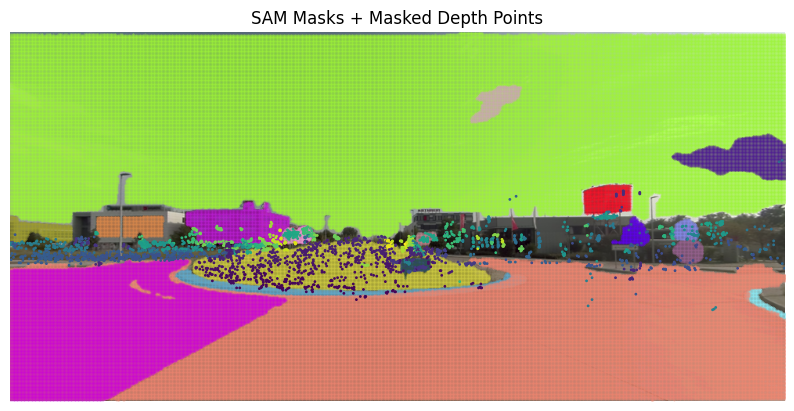

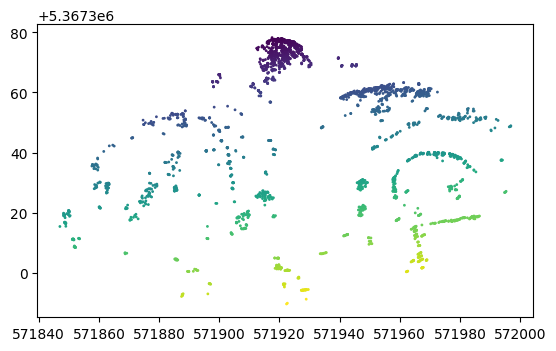

Extracting features:   1%|          | 1/160 [00:04<10:41,  4.03s/it]

18 torch.Size([20, 1024]) torch.Size([471, 990, 1024])


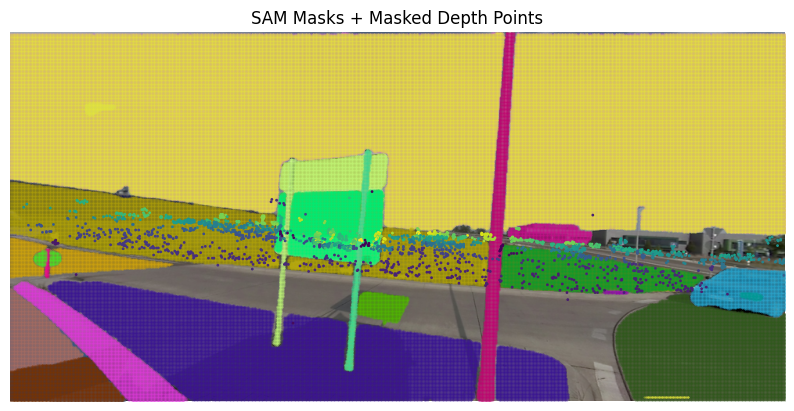

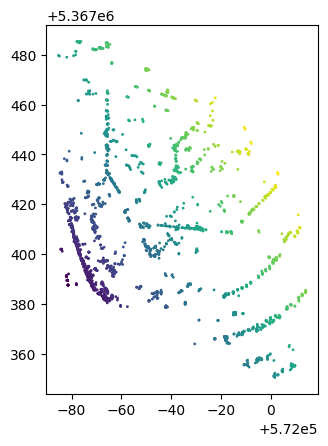

Extracting features:   1%|▏         | 2/160 [00:08<11:14,  4.27s/it]

16 torch.Size([30, 1024]) torch.Size([471, 990, 1024])


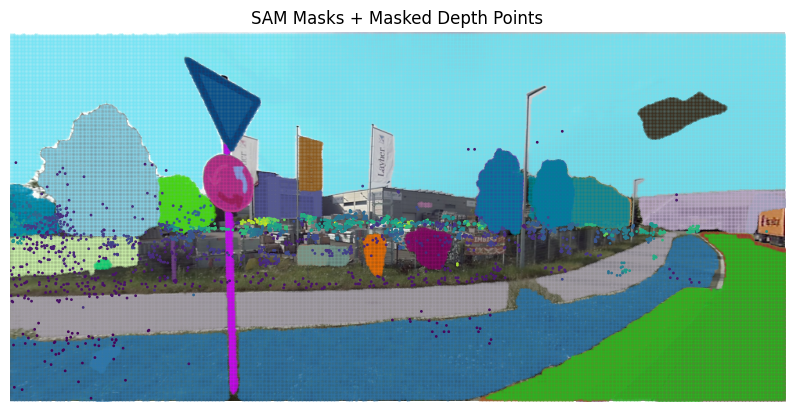

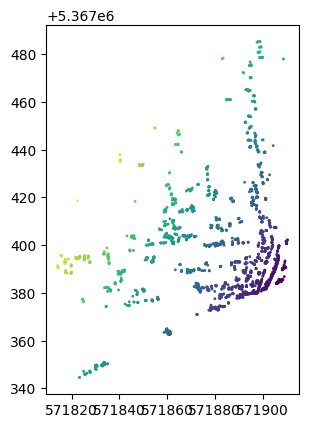

Extracting features:   2%|▏         | 3/160 [00:13<11:34,  4.42s/it]

23 torch.Size([38, 1024]) torch.Size([471, 990, 1024])


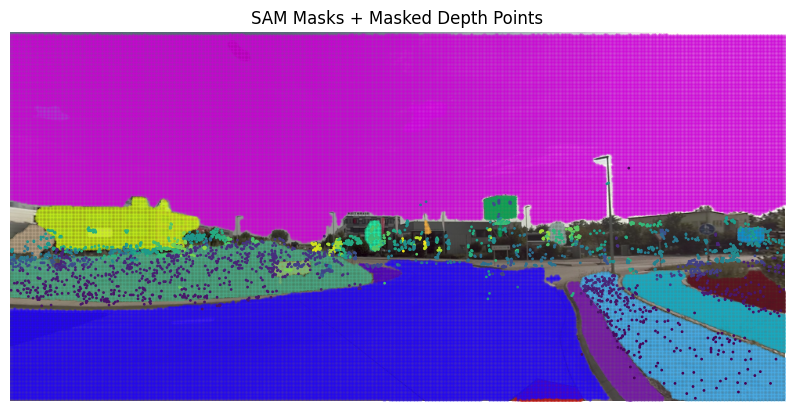

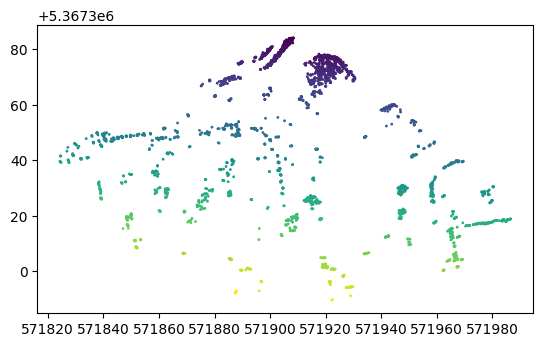

Extracting features:   2%|▎         | 4/160 [00:17<11:27,  4.41s/it]

19 torch.Size([26, 1024]) torch.Size([471, 990, 1024])


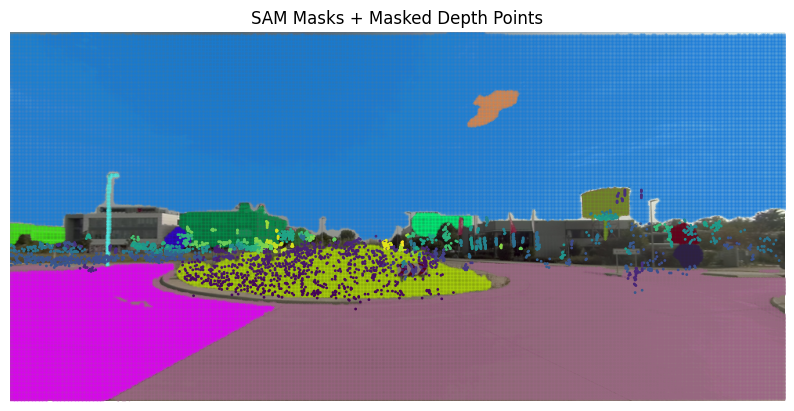

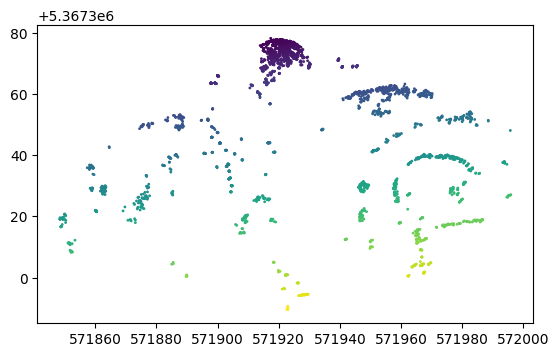

Extracting features:   3%|▎         | 5/160 [00:21<11:08,  4.31s/it]

15 torch.Size([16, 1024]) torch.Size([471, 990, 1024])


Extracting features:   3%|▎         | 5/160 [00:23<12:23,  4.80s/it]


KeyboardInterrupt: 

In [10]:
# extract features for each frame
frames_pcd = []
frames_feats = []
for i in tqdm(range(0, len(dataset), cfg.pipeline.skip_frames), desc="Extracting features"):
    rgb_image, depth_image, pose, _, _ = dataset[i]
    if rgb_image.size != depth_image.size:
        rgb_image = rgb_image.resize(depth_image.size)
    F_2D, F_masks, masks, F_g = extract_feats_per_pixel(
        np.array(rgb_image),
        mask_generator,
        clip_model,
        preprocess,
        clip_feat_dim=clip_feat_dim,
        bbox_margin=cfg.pipeline.clip_bbox_margin,
        maskedd_weight=cfg.pipeline.clip_masked_weight,
    )
    F_2D = F_2D.cpu()

    # print(np.array(pcd.points).shape, np.array(rgb_image).shape, masks[0]["segmentation"].shape)
    
    masks_3d, masks_3d_feats = create_3d_masks(
        dataset,
        masks,
        F_masks,
        depth_image,
        full_pcd,
        tree_pcd,
        pose,
        down_size=cfg.pipeline.voxel_size,
        filter_distance=np.inf #cfg.pipeline.max_mask_distance,
    )
    # Get 2D pixel coordinates from the masked depth
    pcd, (x_depth, y_depth, depth_vals) = create_pcd(dataset, rgb_image, depth_image, pose)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(rgb_image)

    # Plot the SAM segmentation masks
    for mask in masks:
        seg = mask["segmentation"]
        ys, xs = np.where(seg)
        color = np.random.rand(3,)
        ax.scatter(xs, ys, s=0.1, color=color, alpha=0.5, label="Segmentation")

    # Plot the masked depth points
    sc = ax.scatter(x_depth, y_depth, c=depth_vals, cmap='viridis', s=1, alpha=1)

    ax.set_title("SAM Masks + Masked Depth Points")
    plt.axis("off")
    plt.show()
    
    plt.figure()
    plt.scatter(np.array(pcd.points)[:, 0], np.array(pcd.points)[:, 1], c=depth_vals, cmap='viridis', s=1, alpha=1)
    plt.gca().set_aspect('equal')
    plt.show()

    # plt.scatter(
    #     np.asarray(pcd.points)[:, 0],
    #     np.asarray(pcd.points)[:, 1],
    #     s=10, alpha=0.5, c="gray",
    # )
        
    # for mask in masks_3d:
    #     mask.paint_uniform_color(np.random.rand(3,))
    #     # visualize mask in 2D with scatter plot
    #     plt.scatter(
    #         np.asarray(mask.points)[:, 0],
    #         np.asarray(mask.points)[:, 1],
    #         c=np.random.rand(3,),
    #     s=1,
    #     )
    # plt.gca().set_aspect('equal', adjustable='box')
    # plt.show()
    
    # if i > 3:
    #     break
    frames_pcd.append(masks_3d)
    frames_feats.append(masks_3d_feats)
    
    print(len(masks_3d), F_masks.shape, F_2D.shape)
    # fuse features for each point in the full pcd
    mask = np.array(depth_image) > 0
    mask = torch.from_numpy(mask)
    F_2D = F_2D[mask]
    # using cKdtree to find the closest point in the full pcd for each point in frame pcd
    dis, idx = tree_pcd.query(np.asarray(pcd.points), k=1, workers=-1)
    sum_features[idx] += F_2D
    counter[idx] += 1
    # break
    
    # Project 3D to image with masks to see
    

In [ ]:
save_dir = os.path.join(params.main.save_path, params.main.dataset, variation, scene_name, "labelled_frames")


'/home/daniel/spatial_understanding/benchmarks/HOV-SG/truckscenes'

In [ ]:
import os
import numpy as np
import torch

# Directory to hold per-frame files
out_dir = "frames_with_feats"
os.makedirs(out_dir, exist_ok=True)

all_pts = 0
for idx, (frame_pcds, frame_feats) in enumerate(zip(frames_pcd, frames_feats)):
    for j, frame in enumerate(frame_pcds):
        # Print size of each frame's point cloud
        print(f"Frame {idx}_{j}, Point Cloud Size: {len(frame.points)}")
    print(len(frame_pcds), len(frame_feats))

Frame 0_0, Point Cloud Size: 7
Frame 0_1, Point Cloud Size: 739
Frame 0_2, Point Cloud Size: 143
Frame 0_3, Point Cloud Size: 3
Frame 0_4, Point Cloud Size: 2
Frame 0_5, Point Cloud Size: 17
Frame 0_6, Point Cloud Size: 40
Frame 0_7, Point Cloud Size: 12
Frame 0_8, Point Cloud Size: 40
Frame 0_9, Point Cloud Size: 6
Frame 0_10, Point Cloud Size: 62
Frame 0_11, Point Cloud Size: 16
Frame 0_12, Point Cloud Size: 34
Frame 0_13, Point Cloud Size: 97
Frame 0_14, Point Cloud Size: 35
Frame 0_15, Point Cloud Size: 75
Frame 0_16, Point Cloud Size: 2
Frame 0_17, Point Cloud Size: 5
18 18


In [ ]:
from hovsg.utils.graph_utils import (
    compute_3d_bbox_iou,
    find_overlapping_ratio_faiss,
    connected_components,
    merge_point_clouds_list
)
from matplotlib.patches import Rectangle


def plot_top_view_bboxes(ax, bbox_list):
    for i, bbox in enumerate(bbox_list):
        min_bound = bbox.get_min_bound().tolist()  # Ensures it's a list
        max_bound = bbox.get_max_bound().tolist()
        width = max_bound[0] - min_bound[0]  # X-dim
        height = max_bound[1] - min_bound[1]  # Y-dim
        # print(f"Bounding Box {i}: min_bound={min_bound}, max_bound={max_bound}, width={width}, height={height}")
        rect = Rectangle((min_bound[0], min_bound[1]), width, height, linewidth=1.5, color=np.random.rand(3,))
        ax.add_patch(rect)
        # ax.text(min_bound[0], min_bound[1], str(i), fontsize=8, color=f'C{i % 10}')

    # plt.tight_layout()

def merge_3d_masks(mask_list, overlap_threshold=0.5, radius=0.02, iou_thresh=0.05):
    """
    merge the overlapped 3D masks in the list of masks using matrix
    :param pcd_list (list): list of point clouds
    :param overlap_threshold (float): threshold for overlapping ratio
    :param radius (float): radius for faiss search
    :param iou_thresh (float): threshold for iou
    :return: merged point clouds and features
    """
    
    aa_bb = [pcd.get_axis_aligned_bounding_box() for pcd in mask_list]
    overlap_matrix = np.zeros((len(mask_list), len(mask_list)))
    
    # fig, ax = plt.subplots()

    # create matrix of overlapping ratios
    for i in range(len(mask_list)):
        for j in range(i + 1, len(mask_list)):

            if compute_3d_bbox_iou(aa_bb[i], aa_bb[j]) > iou_thresh:
                overlap_matrix[i, j] = find_overlapping_ratio_faiss(mask_list[i], mask_list[j], radius=1.5 * radius)


                # plot_top_view_bboxes(ax, [aa_bb[i], aa_bb[j]])
                # print(np.array(mask_list[i].points).shape, np.array(mask_list[j].points).shape)
                # plt.scatter(np.array(mask_list[i].points)[:, 0], np.array(mask_list[i].points)[:, 1], s=1, c='blue', label='Mask ' + str(i))
                # plt.scatter(np.array(mask_list[j].points)[:, 0], np.array(mask_list[j].points)[:, 1], s=1, c='red', label='Mask ' + str(j))
                # plot_top_view_bboxes(ax, [aa_bb[j]], title="Top View Before Merging")
        #         break
        # break
    
    # ax.set_xlabel('X')
    # ax.set_ylabel('Y')
    # ax.set_aspect('equal', adjustable='box')
    # plt.grid(True)
    # plt.show()

    # check if overlap_matrix is zero size
    if overlap_matrix.size == 0:
        return mask_list
    graph = overlap_matrix > overlap_threshold
    n_components, component_labels = connected_components(graph)
    component_indices = [np.where(component_labels == i)[0] for i in range(n_components)]
    # merge the masks in each component
    pcd_list_merged = []
    for indices in component_indices:
        pcd_list_merged.append(merge_point_clouds_list([mask_list[i] for i in indices], voxel_size=0.5 * radius))

    # fig, ax = plt.subplots()
    # for merged_pcd in pcd_list_merged:
        # Plot the merged point cloud
        # ax.scatter(np.array(merged_pcd.points)[:, 0], np.array(merged_pcd.points)[:, 1], s=1, c=np.random.rand(3,), label='Merged Mask')
    # plt.title("Top View After Merging")
    # ax.set_aspect('equal', adjustable='box')
    # plt.show()

    return pcd_list_merged


def merge_adjacent_frames(frames_pcd, th, down_size, proxy_th):
    """
        Merge adjacent frames in the list of frames
        :param frames_pcd (list): list of point clouds
        :param th (float): threshold for overlapping ratio
        :param down_size (float): radius for downsampling
        :param proxy_th (float): threshold for iou
        :return: merged point clouds and features
    """
    new_frames_pcd = []
    for i in tqdm(range(0, len(frames_pcd), 2)):
        # if the number of frames is odd, the last frame is appended without merging.
        if i == len(frames_pcd) - 1:
            new_frames_pcd.append(frames_pcd[i])
            break
        pcd_list = frames_pcd[i] + frames_pcd[i + 1]

        pcd_list = merge_3d_masks(
            pcd_list,
            overlap_threshold=th,
            radius=down_size,
            iou_thresh=proxy_th,
        )
        new_frames_pcd.append(pcd_list)

    return new_frames_pcd

def hierarchical_merge(frames_pcd, th, th_factor, down_size, proxy_th):
    """
        Hierarchical merge the frames in the list of frames
        :param frames_pcd (list): list of point clouds
        :param th (float): threshold for overlapping ratio
        :param th_factor (float): factor for decreasing the threshold
        :param down_size (float): radius for downsampling
        :param proxy_th (float): threshold for iou
        :return: merged point clouds and features
    """
    while len(frames_pcd) > 1:
        frames_pcd = merge_adjacent_frames(frames_pcd, th, down_size, proxy_th)
        if len(frames_pcd) > 1:
            th -= th_factor * (len(frames_pcd) - 2) / max(1, len(frames_pcd) - 1)
            print("th: ", th)
        break
    # apply one more merge
    frames_pcd = frames_pcd[0]
    frames_pcd = merge_3d_masks(
        frames_pcd, overlap_threshold=0.75, radius=down_size, iou_thresh=proxy_th
    )
    return frames_pcd

In [ ]:
# Plot all the masks for all the frames in frames_pcd
plt.figure(figsize=(10, 10))
for frame in frames_pcd:
    for i, mask_3d in enumerate(frame):
        points = np.asarray(mask_3d.points)
        plt.scatter(points[:, 0], points[:, 1], s=1, c=np.random.rand(3,), label=f"Mask {i}")
plt.title("All Masks from All Frames")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

In [ ]:
full_feats_array.shape

In [ ]:
# compute the average features
counter[counter == 0] = 1e-5
sum_features = sum_features / counter
full_feats_array = sum_features.cpu().numpy()
full_feats_array: np.ndarray

# del sum_features, counter
# torch.cuda.empty_cache() 

# merging the masks
# if cfg.pipeline.merge_type == "hierarchical":
#     tqdm.write("Merging 3d masks hierarchically")
#     mask_pcds = hierarchical_merge(
#         frames_pcd, 
#          0.75, # 0.75, #cfg.pipeline.init_overlap_thresh, 
#          0.025, # 0.025, #cfg.pipeline.overlap_thresh_factor, 
#          0.021, # 0.021, #cfg.pipeline.voxel_size, 
#          0.5, # 0.05, #cfg.pipeline.iou_thresh,
#     )
# elif cfg.pipeline.merge_type == "sequential":
tqdm.write("Merging 3d masks sequentially") 
mask_pcds = seq_merge(
    frames_pcd, 
    0.01, # 0.75, #cfg.pipeline.init_overlap_thresh, 
    0.1, # 0.021, #cfg.pipeline.voxel_size, 
    0.5, # 0.05, #cfg.pipeline.iou_thresh,
)


In [ ]:
# remove any small pcds
for i, pcd in enumerate(mask_pcds):
    if pcd.is_empty() or len(pcd.points) < cfg.pipeline.min_pcd_points:
        mask_pcds.pop(i)
        
# fuse point features in every 3d mask
masks_feats = []
for i, mask_3d in tqdm(enumerate(mask_pcds), desc="Fusing features"):
    # find the points in the mask
    mask_3d = mask_3d.voxel_down_sample(cfg.pipeline.voxel_size * 2)
    points = np.asarray(mask_3d.points)
    dist, idx = tree_pcd.query(points, k=1, workers=-1)
    feats = full_feats_array[idx]
    feats = np.nan_to_num(feats)
    # filter feats with dbscan
    if feats.shape[0] == 0:
        masks_feats.append(
            np.zeros((1, clip_feat_dim), dtype=full_feats_array.dtype)
        )
        continue
    # print("Before", feats.shape)
    # feats = feats_denoise_dbscan(feats, eps=0.01, min_points=100)
    feats = feats_denoise_dbscan(feats, eps=10, min_points=5)
    # print("After", feats.shape)
    
    masks_feats.append(feats)
mask_feats = masks_feats
print("number of masks: ", len(mask_feats))
print("number of pcds in hovsg: ", len(mask_pcds))
assert len(mask_pcds) == len(mask_feats)


In [ ]:
count_points = 0
plt.figure(figsize=(10, 10))
plt.scatter(np.asarray(full_pcd.points)[:, 0], np.asarray(full_pcd.points)[:, 1], s=1, c='gray', alpha=0.5, label="Full PCD")
for i, mask_3d in enumerate(mask_pcds):
    points = np.asarray(mask_3d.points)
    plt.scatter(points[:, 0], points[:, 1], s=1, c=np.random.rand(3,), label=f"Mask {i}")
    count_points += points.shape[0]
plt.title("3D Masks")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
print("Total number of points", np.array(full_pcd.points).shape[0])
print("Total number of points in masks", count_points)

In [ ]:
exit(-1)


In [ ]:
state = "both"
path = os.path.join(cfg.main.save_path, cfg.main.dataset)
# def save_masked_pcds(self, path, state="both"):
# """
# Save the masked pcds to disk
# :params state: str 'both' or 'objects' or 'full' to save the full masked pcds or only the objects.
# """
# # # remove any small pcds
# tqdm.write("-- removing small and empty masks --")
# for i, pcd in enumerate(mask_pcds):
#     if len(pcd.points) < 50:
#         mask_pcds.pop(i)
#         mask_feats.pop(i)

for i, pcd in enumerate(mask_pcds):
    if pcd.is_empty():
        mask_pcds.pop(i)
        mask_feats.pop(i)

objects_path = os.path.join(path, "objects")

if state == "both":
    if not os.path.exists(path):
        os.makedirs(path)
    if not os.path.exists(objects_path):
        os.makedirs(objects_path)
    print("number of masked pcds: ", len(mask_pcds))
    print("number of mask_feats: ", len(mask_feats))
    for i, pcd in enumerate(mask_pcds):
        o3d.io.write_point_cloud(
            os.path.join(objects_path, "pcd_{}.ply".format(i)), pcd
        )

    masked_pcd = o3d.geometry.PointCloud()
    for pcd in mask_pcds:
        pcd.paint_uniform_color(np.random.rand(3))
        masked_pcd += pcd
    o3d.io.write_point_cloud(os.path.join(path, "masked_pcd.ply"), masked_pcd)
    print("masked pcds saved to disk in {}".format(path))

elif state == "objects":
    if not os.path.exists(path):
        os.makedirs(path)
    for i, pcd in enumerate(mask_pcds):
        o3d.io.write_point_cloud(
            os.path.join(objects_path, "pcd_{}.ply".format(i)), pcd
        )
    print("masked pcds saved to disk in {}".format(path))

elif state == "full":
    if not os.path.exists(path):
        os.makedirs(path)
    masked_pcd = o3d.geometry.PointCloud()
    for pcd in mask_pcds:
        pcd.paint_uniform_color(np.random.rand(3))
        masked_pcd += pcd
    o3d.io.write_point_cloud(os.path.join(path, "masked_pcd.ply"), masked_pcd)
    print("masked pcds saved to disk in {}".format(path))


In [ ]:

# def save_full_pcd(self, path):
# """
# Save the full pcd to disk
# :param path: str, The path to save the full pcd
# """
if not os.path.exists(path):
    os.makedirs(path)
o3d.io.write_point_cloud(os.path.join(path, "full_pcd.ply"), full_pcd)
print("full pcd saved to disk in {}".format(path))

In [ ]:

# def save_full_pcd_feats(self, path):
# """
# Save the full pcd with feats to disk
# :param path: str, The path to save the full pcd feats
# """
if not os.path.exists(path):
    os.makedirs(path)
# check if the full pcd feats is empty list
if len(mask_feats) != 0:
    mask_feats = np.array(mask_feats)
    torch.save(
        torch.from_numpy(mask_feats), os.path.join(path, "mask_feats.pt")
    )
if len(full_feats_array) != 0:
    torch.save(
        torch.from_numpy(full_feats_array),
        os.path.join(path, "full_feats.pt"),
    )
print("full pcd feats saved to disk in {}".format(path))

In [ ]:
import torch 
import pickle
import os
import numpy as np
scene = "scene-0c2e941c5ba2476b9e20b29ce4c678b9-3"
scene_path = f"/home/daniel/spatial_understanding/benchmarks/HOV-SG/truckscenes/modified_seq_merge_params/{scene}"
labelled_path = os.path.join(scene_path, "labelled_frames")
labelled_frames_paths = sorted(os.listdir(labelled_path), key=lambda x: int(x.split('_')[-1].split('.')[0]))

labelled_map_path = f"/shared/data/truckScenes/truckscenes_converted/trainval/{scene}/labelled_map.pth"
xyz, _, label, _ = torch.load(labelled_map_path, weights_only=False)


(6, 3)
[0.05016479 0.01077421 0.01355021 0.0525     0.05569156 0.03794438]
(716, 3)
[0.00160698 0.0020463  0.00404281 0.01162769 0.00394792 0.00506649
 0.01249131 0.00508059 0.01360524 0.00380496 0.01162692 0.00796376
 0.0054944  0.00864156 0.02855791 0.00394092 0.00222414 0.00332903
 0.01556277 0.01038238 0.00343252 0.03005856 0.01444597 0.00128371
 0.00568297 0.01372339 0.0075152  0.01028629 0.00350033 0.01341129
 0.00287546 0.00884801 0.0046469  0.01247685 0.01260581 0.00704377
 0.00530952 0.00558312 0.01464654 0.00590362 0.00258763 0.01130621
 0.00387819 0.0073004  0.01414208 0.00666608 0.00996129 0.0030848
 0.01026153 0.00921631 0.01257709 0.00944446 0.01389972 0.00839379
 0.01418624 0.01348596 0.00789223 0.01185138 0.00870573 0.01190924
 0.01883755 0.01388433 0.01240493 0.00343164 0.01313076 0.01042403
 0.00869248 0.01527813 0.00758675 0.01476123 0.01660345 0.00462913
 0.01739582 0.01480994 0.01388245 0.01492007 0.01005303 0.00603736
 0.0706495  0.01442815 0.02836525 0.00113364 0

/tmp/ipykernel_1970067/3825727698.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(points[:, 0], points[:, 1], s=1, c=np.random.rand(3,), label="PCD")


(7, 3)
[0.00438012 0.00715643 0.005587   0.01498986 0.00967971 0.00853052
 0.00773154]
(66, 3)
[0.02412639 0.03595363 0.03139278 0.02385735 0.05640546 0.00259064
 0.04649049 0.00781486 0.02617325 0.02603369 0.02408734 0.01747014
 0.01930542 0.03293677 0.00631265 0.02342814 0.01260303 0.01519058
 0.02544018 0.01446695 0.01457972 0.01913009 0.0259259  0.00851932
 0.02755234 0.01018203 0.02138315 0.018411   0.03874887 0.00964827
 0.00983239 0.04247851 0.02527085 0.02018153 0.01975008 0.01438581
 0.02210404 0.03477322 0.00735154 0.02303662 0.03092543 0.02412093
 0.02911395 0.02204839 0.01788934 0.0126855  0.02699512 0.02498801
 0.02714597 0.02307529 0.03263695 0.01401848 0.03650886 0.03871348
 0.03963008 0.00348579 0.02271167 0.02935516 0.00134577 0.01917279
 0.03891002 0.0050899  0.00641708 0.02065616 0.01349384 0.02091546]
(145, 3)
[0.03139278 0.03293677 0.05640546 0.0050899  0.01018203 0.03891002
 0.01090137 0.01610246 0.02204839 0.06358423 0.07892018 0.0265741
 0.03477322 0.03005094 0.

KeyboardInterrupt: 

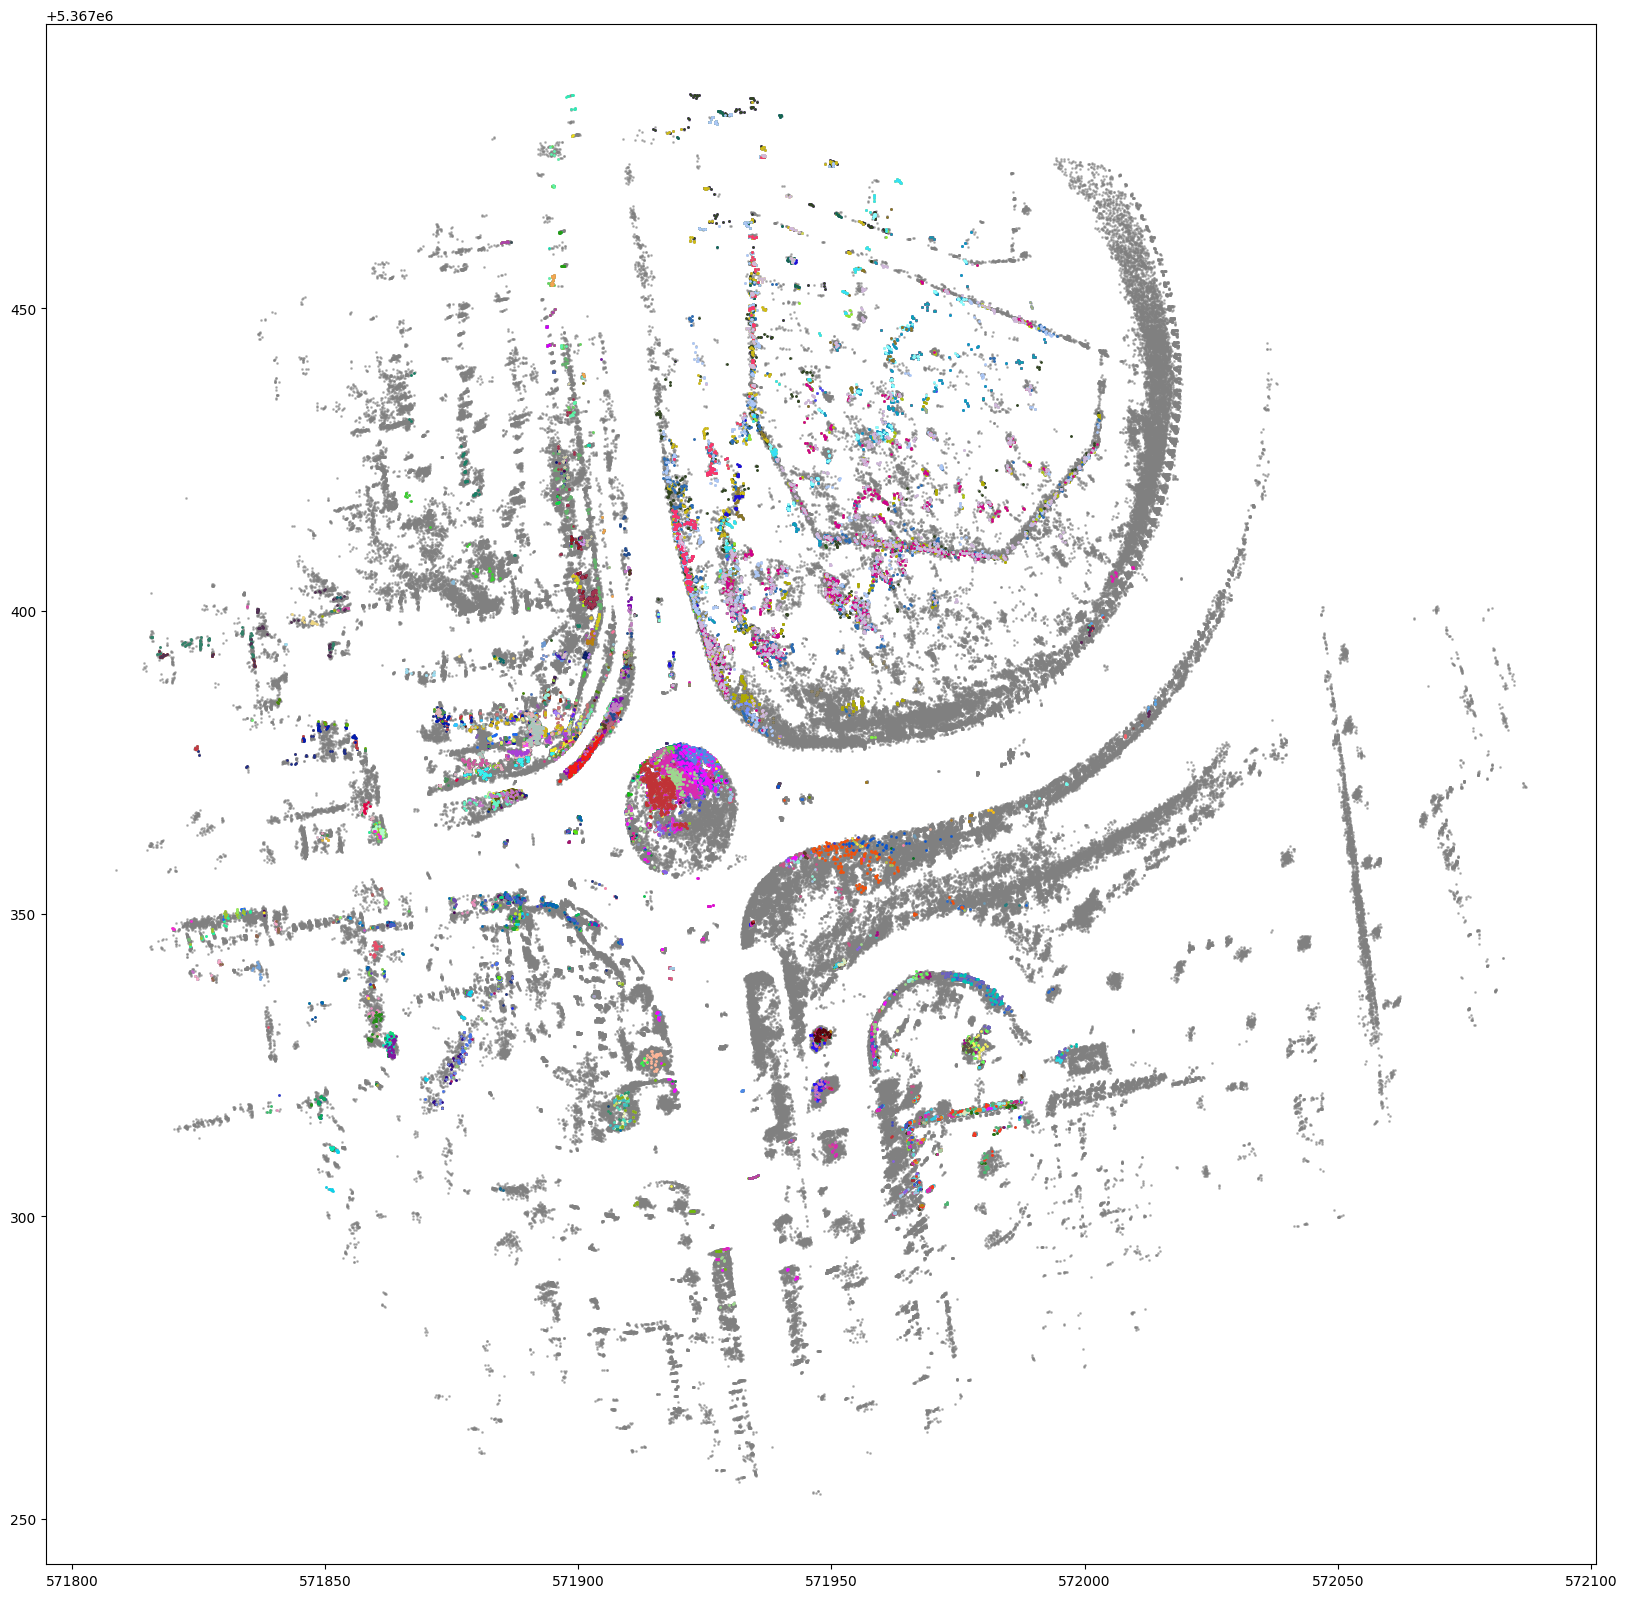

In [ ]:
from scipy.spatial import cKDTree
tree = cKDTree(xyz[:, :3])
    
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.scatter(xyz[:, 0], xyz[:, 1], s=1, c='gray', alpha=0.5, label="Full Map")

    
for frame_path in labelled_frames_paths:
    frame_path = os.path.join(labelled_path, frame_path)
    with open(frame_path, 'rb') as f:
        frame_data = pickle.load(f)
        
    # print(f"Frame: {frame_path}, Data: {frame_data.keys()}")
    # Do something with the frame data
    # For example, you can access the point cloud and features like this:
    pcds = frame_data['points']
    feats = frame_data['features']
    
    labels = []
    for pcd, feat in zip(pcds, feats):
        print(pcd.shape)
        # Get the labels of the pcd by querying a kdtree with the full labelled map
        dist, idx = tree.query(pcd, k=1, workers=-1)
        print(dist)
        labels.append(label[idx])


    # Plot current pcd and full map
    for points, feat in zip(pcds, feats):
        plt.scatter(points[:, 0], points[:, 1], s=1, c=np.random.rand(3,), label="PCD")
        
plt.title("3D Masks")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

    # print(len(labels), len(pcds))